<a href="https://colab.research.google.com/github/khanh-2004/Week3_pandas/blob/main/1_Data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1 | Setup

##Step 1.1 | Importing Necessary Libraries

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import pycountry_convert as pc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

%matplotlib inline

In [ ]:
!pip install pycountry_convert pandas

In [ ]:
# Initialize Plotly for use in the notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

##Step 1.2 | Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/phantichdulieu/geographic_product_demand_dataset_10M.csv', encoding="ISO-8859-1")
df.shape

(10000000, 11)

#Step 2 | Initial Data Analysis

##Step 2.1 | Dataset Overview

In [ ]:
df.head(10)

,Location ID,City,State,Country,Latitude,Longitude,Product ID,Product Category,Sales Volume,Sales Revenue,Date
0,1,Tokyo,NaN,Japan,35.6895,139.6917,FOOD6004,Coffee,60.0,1014.52,2023-11-16
1,2,Hyderabad,Telangana,India,17.3850,78.4867,BOOK5004,Self-help Book,86.4,3321.36,2022-02-10
2,3,Delhi,Delhi,India,28.7041,77.1025,BOOK5001,Novel,59.0,1244.63,2022-12-05
3,4,Toronto,NaN,Canada,43.6510,-79.3470,FOOD6005,Energy Drinks,18.0,237.82,2024-08-01
4,5,Chicago,IL,USA,41.8781,-87.6298,HOME3003,Bed,56.0,30791.05,2024-07-13
5,6,Chicago,IL,USA,41.8781,-87.6298,ELEC1008,Bluetooth Speaker,81.6,7192.71,2024-07-09
6,7,New York,NY,USA,40.7128,-74.0060,ELEC1005,Headphones,120.0,32710.80,2022-05-22
7,8,Chennai,Tamil Nadu,India,13.0827,80.2707,HOME3001,Sofa,14.0,18373.16,2023-05-22
8,9,Toronto,NaN,Canada,43.6510,-79.3470,HOME3004,Microwave,25.0,4600.74,2023-05-27
9,10,Mumbai,Maharashtra,India,19.0760,72.8777,CLOT2004,Jeans,71.4,6022.37,2022-12-20


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Location ID       int64  
 1   City              object 
 2   State             object 
 3   Country           object 
 4   Latitude          float64
 5   Longitude         float64
 6   Product ID        object 
 7   Product Category  object 
 8   Sales Volume      float64
 9   Sales Revenue     float64
 10  Date              object 
dtypes: float64(4), int64(1), object(6)
memory usage: 839.2+ MB


##Step 2.2 | Summary Statistics

In [ ]:
df['Location ID'] = df['Location ID'].astype(object)

In [ ]:
# Summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,10000000.0,29.703422,19.067228,-33.8688,19.076,34.0522,41.8781,52.5200
Longitude,10000000.0,15.942250,85.651461,-118.2437,-79.347,13.4050,78.4867,151.2093
Sales Volume,10000000.0,74.632341,40.289670,7.2000,42.000,71.0000,102.0000,355.5000
Sales Revenue,10000000.0,21657.526726,37254.497727,34.5900,1873.370,5402.0500,22060.9050,585849.8300


In [ ]:
# Summary statistics for categorical variables
df.describe(include='object').T

,count,unique,top,freq
Location ID,10000000,10000000,9999984,1
City,10000000,17,Tokyo,779539
State,6293182,11,NY,732956
Country,10000000,8,India,3463835
Product ID,10000000,35,ELEC1002,286648
Product Category,10000000,35,Laptop,286648
Date,10000000,944,2024-07-31,10943


#Step 3 | Data Cleaning & Transformation

##Step 3.1 | Handling Missing Values

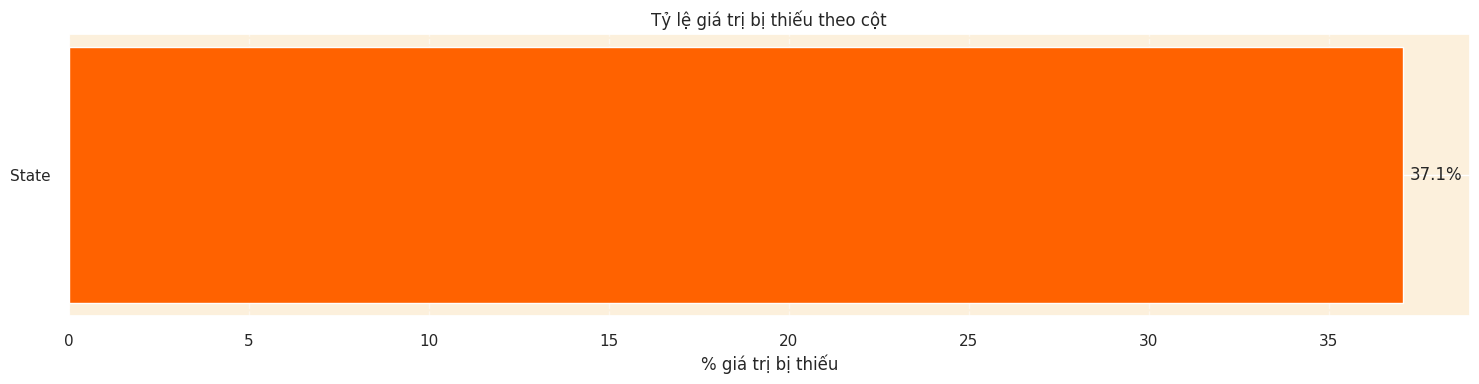

In [ ]:
# Tính phần trăm giá trị bị thiếu cho từng cột
missing_percent = df.isnull().mean() * 100

# Sắp xếp giảm dần theo phần trăm giá trị bị thiếu
missing_percent_sorted = missing_percent.sort_values(ascending=False)

# Lọc bỏ các cột không có giá trị bị thiếu (nếu muốn)
missing_percent_sorted = missing_percent_sorted[missing_percent_sorted > 0]

# Vẽ biểu đồ thanh ngang
fig, ax = plt.subplots(figsize=(15, 4))
bars = ax.barh(missing_percent_sorted.index, missing_percent_sorted.values, color='#ff6200')

# Thêm nhãn phần trăm vào bên phải mỗi thanh
for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.1f}%',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0),  # Dịch nhãn sang phải
                textcoords='offset points',
                ha='left', va='center')

# Tùy chỉnh biểu đồ
ax.set_xlabel('% giá trị bị thiếu')
ax.set_title('Tỷ lệ giá trị bị thiếu theo cột')
ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# Danh sách các cột có dữ liệu bị thiếu
cols_with_missing = missing_percent_sorted.index.tolist()

# Số hàng ban đầu
num_rows_before = df.shape[0]

# Xóa các hàng có thiếu dữ liệu trong các cột đó
df_cleaned = df.dropna(subset=cols_with_missing)

# Số hàng sau khi xóa
num_rows_after = df_cleaned.shape[0]

# Số hàng đã bị loại bỏ
rows_dropped = num_rows_before - num_rows_after

print(f'Tổng số hàng trước khi làm sạch: {num_rows_before}')
print(f'Tổng số hàng sau khi làm sạch: {num_rows_after}')
print(f'Đã loại bỏ {rows_dropped} hàng có giá trị thiếu')


Tổng số hàng trước khi làm sạch: 10000000
Tổng số hàng sau khi làm sạch: 6293182
Đã loại bỏ 3706818 hàng có giá trị thiếu


In [ ]:
df.shape[0]

10000000

##Step 3.2 | Handling Duplicates

In [ ]:
# Sắp xếp dữ liệu để dễ quan sát các dòng trùng
df_sorted = df.sort_values(by=['City', 'Country', 'Product ID', 'Sales Volume', 'Date'])

# Tìm các dòng trùng lặp theo các cột chính
duplicates = df_sorted[df_sorted.duplicated(
    subset=['City', 'Country', 'Product ID', 'Sales Volume', 'Date'],
    keep=False
)]

# Hiển thị 10 bản ghi trùng lặp đầu tiên
duplicates.head(10)


,Location ID,City,State,Country,Latitude,Longitude,Product ID,Product Category,Sales Volume,Sales Revenue,Date
317249,317250,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,230.40,2022-01-01
1259810,1259811,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,402.83,2022-01-01
4873243,4873244,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,422.15,2022-01-10
6767523,6767524,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,214.81,2022-01-10
1893552,1893553,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,316.02,2022-02-06
4600223,4600224,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,330.04,2022-02-06
277772,277773,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,321.59,2022-07-24
7253909,7253910,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,221.86,2022-07-24
1013959,1013960,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,245.69,2022-08-29
7619464,7619465,Bangalore,Karnataka,India,12.9716,77.5946,BOOK5001,Novel,12.0,204.41,2022-08-29


In [ ]:
# Tổng số giá trị thiếu trong mỗi cột
print(df.isnull().sum())

Location ID               0
City                      0
State               3706818
Country                   0
Latitude                  0
Longitude                 0
Product ID                0
Product Category          0
Sales Volume              0
Sales Revenue             0
Date                      0
dtype: int64


In [ ]:
# Xoá các cột có hơn 50% giá trị bị thiếu
threshold = 0.5
df = df.loc[:, df.isnull().mean() < threshold]

# Xoá các dòng có bất kỳ giá trị nào bị thiếu
df = df.dropna()

# Xử lý trùng lặp theo các cột cụ thể
cols_check_dup = ['City', 'Country', 'Product Category']

# Đếm số dòng trùng
num_duplicates_subset = df.duplicated(subset=cols_check_dup).sum()
print(f"Số lượng dòng trùng lặp theo các cột {cols_check_dup}: {num_duplicates_subset}")

# Loại bỏ trùng lặp, giữ lại dòng đầu tiên
df_cleaned_subset = df.drop_duplicates(subset=cols_check_dup, keep='first')

# Kiểm tra trùng lặp còn lại
remaining_duplicates = df_cleaned_subset.duplicated(subset=cols_check_dup).sum()
print(f"Số dòng trùng lặp còn lại: {remaining_duplicates}")


Số lượng dòng trùng lặp theo các cột ['City', 'Country', 'Product Category']: 6292797
Số dòng trùng lặp còn lại: 0


In [ ]:
# Lấy số lượng hàng trong dataframe
df.shape[0]

6293182

##Step 3.3 | Correcting Product ID Anomalies

In [ ]:
print(df.columns.tolist())


['Location ID', 'City', 'State', 'Country', 'Latitude', 'Longitude', 'Product ID', 'Product Category', 'Sales Volume', 'Sales Revenue', 'Date']


In [ ]:
# Đếm số lượng product_id duy nhất
unique_product_ids = df['Product ID'].nunique()
print(f"Số lượng mã sản phẩm duy nhất: {unique_product_ids}")


Số lượng mã sản phẩm duy nhất: 35


In [ ]:
# Kiểm tra các product_id bị thiếu hoặc rỗng
missing_product_ids = df['Product ID'].isnull().sum()
print(f"Số lượng bản ghi thiếu Product ID: {missing_product_ids}")

Số lượng bản ghi thiếu Product ID: 0


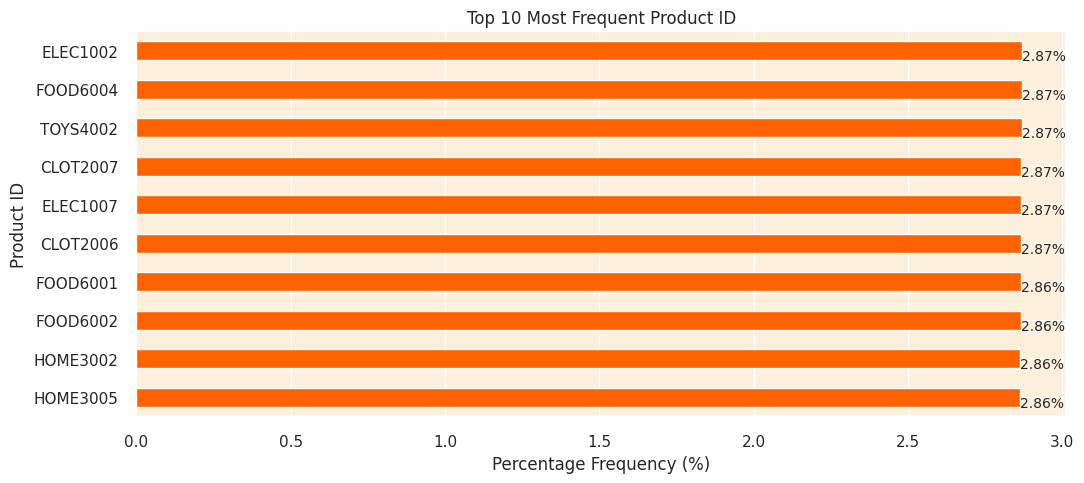

In [ ]:
# Đếm số lần xuất hiện của từng product_id
product_counts = df['Product ID'].value_counts()

# Tính phần trăm tần suất
product_percent = (product_counts / len(df)) * 100

# Lấy 10 mã sản phẩm phổ biến nhất
top_10_stock_codes = product_percent.head(10)

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Thêm %
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Product ID')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Product ID')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Tìm số ký tự số trong mỗi mã Product ID duy nhất
unique_product_ids = df['Product ID'].unique()
numeric_char_counts = pd.Series(unique_product_ids).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# In số lượng giá trị cho mã Product ID duy nhất theo số ký tự số
print("Value counts of numeric character frequencies in unique Product ID:")
print("-" * 70)
print(numeric_char_counts)


Value counts of numeric character frequencies in unique Product ID:
----------------------------------------------------------------------
4    35
Name: count, dtype: int64


In [ ]:
# Tìm số ký tự chữ trong mỗi mã Product ID duy nhất
unique_product_ids = df['Product ID'].unique()
alpha_char_counts = pd.Series(unique_product_ids).apply(lambda x: sum(c.isalpha() for c in str(x))).value_counts()

# In số lượng giá trị cho mã Product ID duy nhất theo số ký tự chữ
print("Value counts of alphabetic character frequencies in unique proProduct IDduct_id:")
print("-" * 70)
print(alpha_char_counts)


Value counts of alphabetic character frequencies in unique proProduct IDduct_id:
----------------------------------------------------------------------
4    35
Name: count, dtype: int64


In [ ]:
# Tìm số ký tự đặc biệt trong mỗi mã Product ID duy nhất
unique_product_ids = df['Product ID'].unique()
special_char_counts = pd.Series(unique_product_ids).apply(
    lambda x: sum(not c.isalnum() for c in str(x))
).value_counts()

# In số lượng mã theo số ký tự đặc biệt
print("Value counts of special character frequencies in unique Product ID:")
print("-" * 70)
print(special_char_counts)


Value counts of special character frequencies in unique Product ID:
----------------------------------------------------------------------
0    35
Name: count, dtype: int64


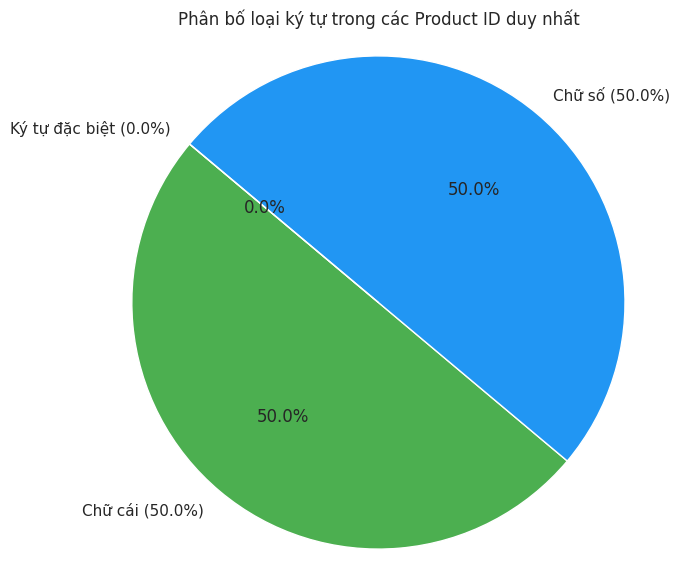

In [ ]:
unique_ids = df['Product ID'].dropna().astype(str)

# Đếm từng loại ký tự
letter_count = unique_ids.apply(lambda x: sum(c.isalpha() for c in x)).sum()
digit_count = unique_ids.apply(lambda x: sum(c.isdigit() for c in x)).sum()
special_count = unique_ids.apply(lambda x: sum(not c.isalnum() for c in x)).sum()

# Tổng số ký tự
total_chars = letter_count + digit_count + special_count

# Tính phần trăm
percentages = {
    'Chữ cái': (letter_count / total_chars) * 100,
    'Chữ số': (digit_count / total_chars) * 100,
    'Ký tự đặc biệt': (special_count / total_chars) * 100
}

# Vẽ biểu đồ tròn
plt.figure(figsize=(7, 7))
plt.pie(percentages.values(),
        labels=[f'{k} ({v:.1f}%)' for k, v in percentages.items()],
        colors=['#4CAF50', '#2196F3', '#FF5722'],
        autopct='%1.1f%%',
        startangle=140)
plt.title('Phân bố loại ký tự trong các Product ID duy nhất')
plt.axis('equal')
plt.show()

In [ ]:
# Lấy số lượng hàng trong dataframe
df.shape[0]

6293182

##Step 3.4 | Cleaning Product Category Column




In [ ]:
print(df.columns.tolist())


['Location ID', 'City', 'State', 'Country', 'Latitude', 'Longitude', 'Product ID', 'Product Category', 'Sales Volume', 'Sales Revenue', 'Date']


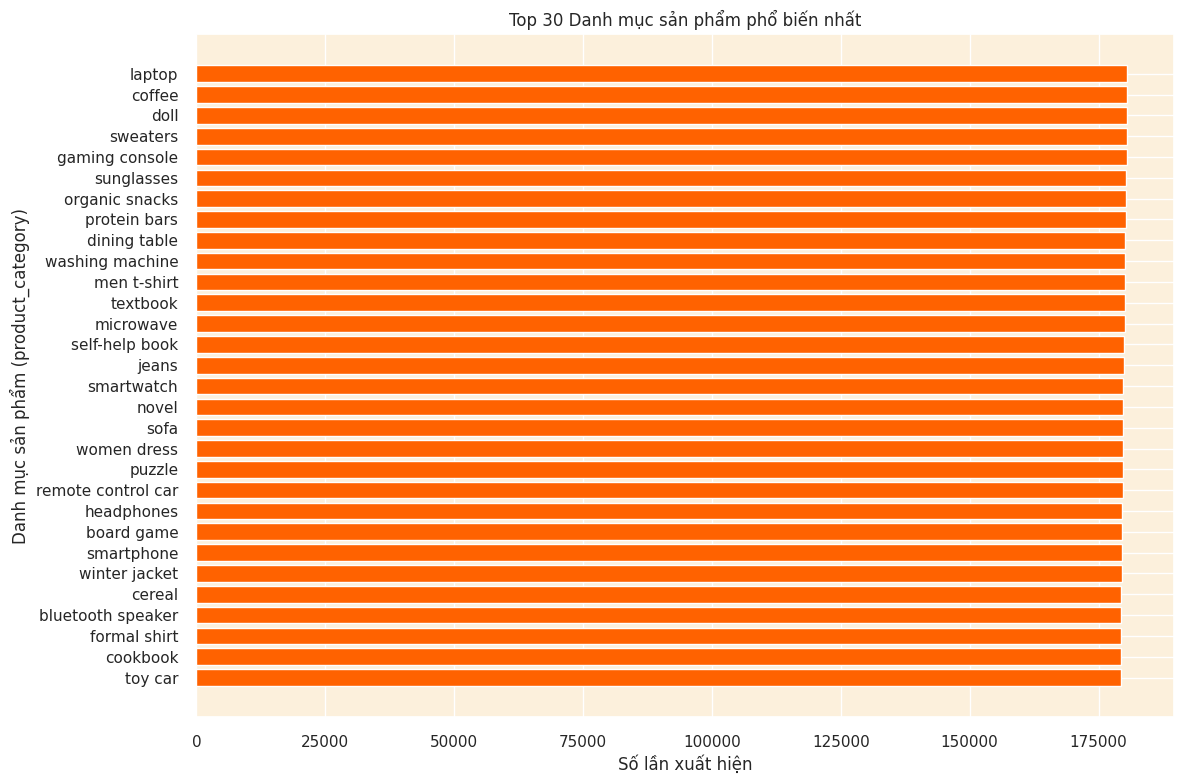

In [ ]:
# Chuyển về chữ thường và loại bỏ khoảng trắng thừa
df['product_category_clean'] = df['Product Category'].str.strip().str.lower()

# Đếm tần suất các mô tả duy nhất và lấy top 30
top_30_descriptions = df['product_category_clean'].value_counts().head(30)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Thêm nhãn và tiêu đề
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Danh mục sản phẩm (product_category)')
plt.title('Top 30 Danh mục sản phẩm phổ biến nhất')
plt.tight_layout()
plt.show()

In [ ]:
# Lấy danh sách các giá trị duy nhất trong cột 'Product Category'
product_categories = df['Product Category'].dropna().unique()

# Lọc ra các giá trị có chứa ít nhất một ký tự viết thường
lowercase_categories = [cat for cat in product_categories if any(char.islower() for char in str(cat))]

# In các giá trị duy nhất có chứa ký tự viết thường
print("The unique 'Product Category' values containing lowercase characters are:")
print("-" * 60)
for cat in lowercase_categories:
    print(cat)


The unique 'Product Category' values containing lowercase characters are:
------------------------------------------------------------
Self-help Book
Novel
Bed
Bluetooth Speaker
Headphones
Sofa
Jeans
Sweaters
Running Shoes
Microwave
Toy Car
Textbook
Winter Jacket
Energy Drinks
Sunglasses
Coffee
Puzzle
Protein Bars
Board Game
Smartphone
Organic Snacks
Smartwatch
Washing Machine
Doll
Tablet
Formal Shirt
Remote Control Car
Gaming Console
Camera
Laptop
Cereal
Women Dress
Cookbook
Men T-shirt
Dining Table


Các ký tự đặc biệt được tìm thấy trong cột 'Product Category':
------------------------------------------------------------
-    360150
Name: count, dtype: int64


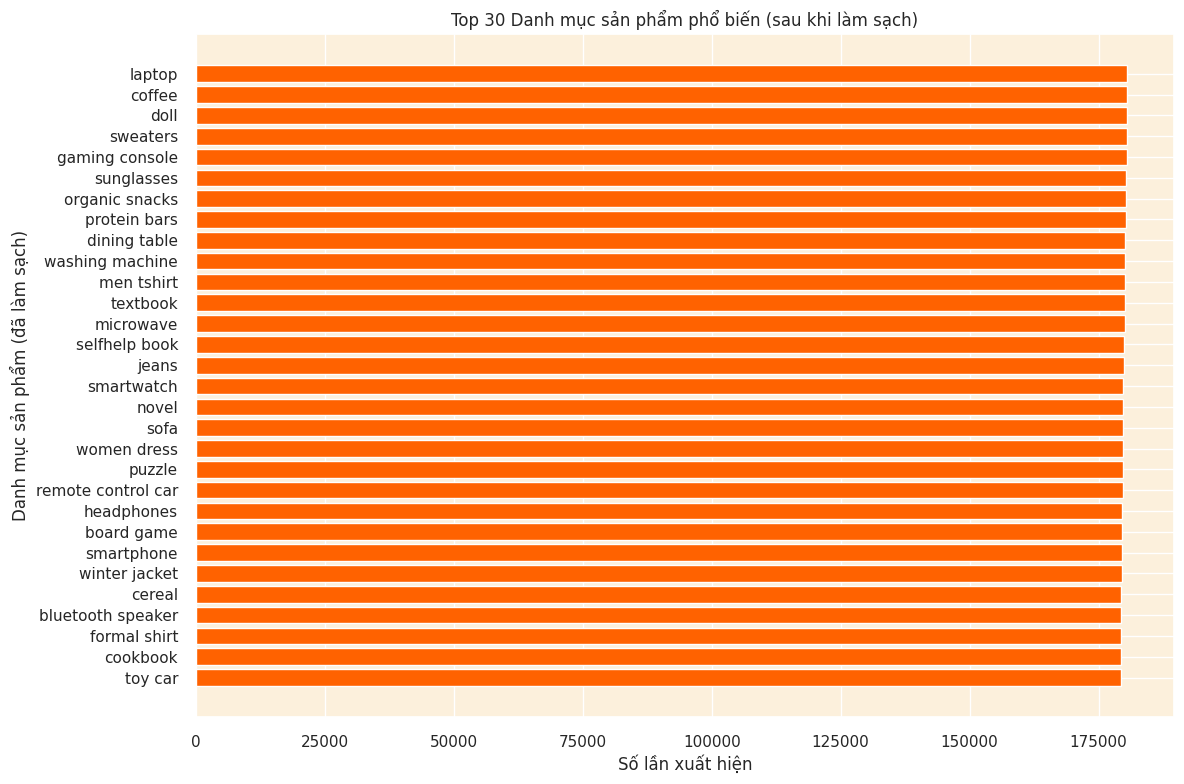

In [ ]:
# Hàm tìm ký tự đặc biệt
def extract_special_chars(text):
    if pd.isnull(text):
        return ''
    return ''.join(re.findall(r'[^a-zA-Z0-9\s]', str(text)))

# Lấy tất cả các ký tự đặc biệt từ cột product_category
special_chars_series = df['Product Category'].dropna().apply(extract_special_chars)
all_special_chars = ''.join(special_chars_series.tolist())

# Đếm tần suất từng ký tự đặc biệt
special_char_counts = pd.Series(list(all_special_chars)).value_counts()

# Hiển thị các ký tự đặc biệt và tần suất của chúng
print("Các ký tự đặc biệt được tìm thấy trong cột 'Product Category':")
print("-" * 60)
print(special_char_counts)

# Làm sạch văn bản sau khi hiển thị
def clean_text(text):
    if pd.isnull(text):
        return text
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Loại bỏ ký tự đặc biệt
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Tạo cột mới với văn bản đã làm sạch
df['product_category_clean'] = df['Product Category'].apply(clean_text)

# Lấy 30 danh mục phổ biến nhất
top_30_descriptions = df['product_category_clean'].value_counts().head(30)

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')
plt.xlabel('Số lần xuất hiện')
plt.ylabel('Danh mục sản phẩm (đã làm sạch)')
plt.title('Top 30 Danh mục sản phẩm phổ biến (sau khi làm sạch)')
plt.tight_layout()
plt.show()


In [ ]:
df.shape[0]

6293182

##Step 3.5 | Treating Sales Revenue

In [ ]:
print(df.columns.tolist())


['Location ID', 'City', 'State', 'Country', 'Latitude', 'Longitude', 'Product ID', 'Product Category', 'Sales Volume', 'Sales Revenue', 'Date', 'product_category_clean']


In [ ]:
# Kiểm tra số lượng giá trị thiếu
missing_count = df['Sales Revenue'].isnull().sum()
print(f"Số bản ghi thiếu doanh thu: {missing_count}")

# Xử lý: Có thể xóa hoặc điền giá trị trung bình/0 tùy mục đích
df = df.dropna(subset=['Sales Revenue'])  # Cách thường dùng: xóa các bản ghi thiếu


Số bản ghi thiếu doanh thu: 0


In [ ]:
# Chuyển tất cả thành chuỗi để xử lý văn bản
df['Sales Revenue'] = df['Sales Revenue'].astype(str)

# Loại bỏ các ký tự không phải số hoặc dấu chấm (giá trị tiền tệ như $, , ...)
df['Sales Revenue'] = df['Sales Revenue'].str.replace(r'[^0-9.]', '', regex=True)

# Chuyển đổi thành số (float)
df['Sales Revenue'] = pd.to_numeric(df['Sales Revenue'], errors='coerce')

#  Xử lý giá trị NaN hoặc âm
df = df[df['Sales Revenue'].notna()]          # Loại bỏ NaN
df = df[df['Sales Revenue'] >= 0]             # Loại bỏ giá trị âm (nếu có)

# Kiểm tra sau khi làm sạch
print(df['Sales Revenue'].describe())


count    6.293182e+06
mean     2.103072e+04
std      3.613563e+04
min      3.459000e+01
25%      1.821260e+03
50%      5.247220e+03
75%      2.143715e+04
max      5.511552e+05
Name: Sales Revenue, dtype: float64


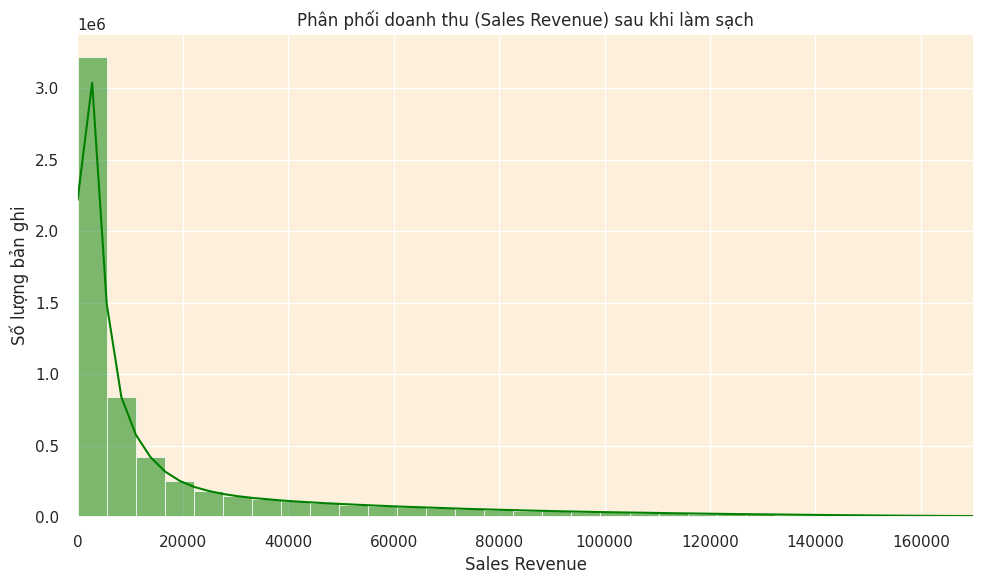

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales Revenue'], bins=100, kde=True, color='green')
plt.title("Phân phối doanh thu (Sales Revenue) sau khi làm sạch")
plt.xlabel("Sales Revenue")
plt.ylabel("Số lượng bản ghi")
plt.xlim(0, df['Sales Revenue'].quantile(0.99))  # Giới hạn trục X để dễ nhìn
plt.tight_layout()
plt.show()


In [ ]:
df.shape[0]

6293182

In [ ]:
# xuất file data_cleaned
df.to_csv('data_cleaned.csv', index=False)


#Step 4 | Feature Engineering

##Step 4.1 | RFM Features

###Step 4.1.1 | Recency (R)

In [ ]:
# Chuyển cột Date sang kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])

# Xác định ngày tham chiếu là ngày mới nhất trong dữ liệu
reference_date = df['Date'].max()

# Tính Recency: số ngày kể từ lần mua gần nhất
customer_data = df.groupby('Location ID')['Date'].max().reset_index()
customer_data.columns = ['Location ID', 'Last Purchase Date']
customer_data['Recency'] = (reference_date - customer_data['Last Purchase Date']).dt.days

# Hiển thị 5 dòng đầu
customer_data.head()


,Location ID,Last Purchase Date,Recency
0,2,2022-02-10,903
1,3,2022-12-05,605
2,5,2024-07-13,19
3,6,2024-07-09,23
4,7,2022-05-22,802


###Step 4.1.2 | Frequency (F)

In [ ]:
# Tính Frequency: số lần mua hàng (số giao dịch) theo Location ID
frequency_df = df.groupby('Location ID').size().reset_index(name='Frequency')

# Kết hợp với bảng customer_data đã có Recency
customer_data = customer_data.merge(frequency_df, on='Location ID', how='left')

# Hiển thị 5 dòng đầu
customer_data.head()


,Location ID,Last Purchase Date,Recency,Frequency
0,2,2022-02-10,903,1
1,3,2022-12-05,605,1
2,5,2024-07-13,19,1
3,6,2024-07-09,23,1
4,7,2022-05-22,802,1


###Step 4.1.3 | Monetary (M)

In [ ]:
# Tính Monetary: tổng Sales Revenue theo Location ID
monetary_df = df.groupby('Location ID')['Sales Revenue'].sum().reset_index(name='Monetary')

# Kết hợp với bảng customer_data đã có Recency và Frequency
customer_data = customer_data.merge(monetary_df, on='Location ID', how='left')

# Hiển thị 5 dòng đầu
customer_data.head()


,Location ID,Last Purchase Date,Recency,Frequency,Monetary
0,2,2022-02-10,903,1,3321.36
1,3,2022-12-05,605,1,1244.63
2,5,2024-07-13,19,1,30791.05
3,6,2024-07-09,23,1,7192.71
4,7,2022-05-22,802,1,32710.80


##Step 4.2 | Product Diversity

In [ ]:
# Tính số lượng danh mục sản phẩm khác nhau mà mỗi khách hàng đã mua
diversity_df = df.groupby('Location ID')['product_category_clean'].nunique().reset_index(name='Product_Diversity')

# Gộp với bảng customer_data
customer_data = customer_data.merge(diversity_df, on='Location ID', how='left')

# Xem kết quả
customer_data.head()


,Location ID,Last Purchase Date,Recency,Frequency,Monetary,Product_Diversity
0,2,2022-02-10,903,1,3321.36,1
1,3,2022-12-05,605,1,1244.63,1
2,5,2024-07-13,19,1,30791.05,1
3,6,2024-07-09,23,1,7192.71,1
4,7,2022-05-22,802,1,32710.80,1


##Step 4.3 | Behavioral Features

In [ ]:
#trung bình số lần mua hàng/tháng

df['Date'] = pd.to_datetime(df['Date'])

# Tính ngày min và max theo mỗi Location ID
min_max_dates = df.groupby('Location ID')['Date'].agg(['min', 'max'])

# Tính số tháng theo sự chênh lệch năm và tháng
min_max_dates['active_months'] = (min_max_dates['max'].dt.year - min_max_dates['min'].dt.year) * 12 + \
                                (min_max_dates['max'].dt.month - min_max_dates['min'].dt.month) + 1  # +1 để tính tháng đầu

# Hoặc tính số tháng xấp xỉ bằng cách dùng số ngày chia 30
# min_max_dates['active_months'] = ((min_max_dates['max'] - min_max_dates['min']).dt.days / 30).round(1)

# Tính số giao dịch
transaction_counts = df.groupby('Location ID').size()

# Tính tần suất mua hàng trung bình (số lần mua hàng trên tháng)
avg_purchase_freq = (transaction_counts / min_max_dates['active_months']).reset_index(name='Avg_Purchase_Frequency')

# Gộp kết quả vào customer_data
customer_data = customer_data.merge(avg_purchase_freq, on='Location ID', how='left')

# Hiển thị một vài dòng để kiểm tra
print(customer_data[['Location ID', 'Avg_Purchase_Frequency']].head())

   Location ID  Avg_Purchase_Frequency
0            2                     1.0
1            3                     1.0
2            5                     1.0
3            6                     1.0
4            7                     1.0


In [ ]:
#thời gian trung bình giữa các giao dịch
# Sắp xếp theo khách hàng và thời gian
df_sorted = df.sort_values(['Location ID', 'Date'])

# Tính thời gian giữa các lần mua
df_sorted['prev_date'] = df_sorted.groupby('Location ID')['Date'].shift(1)
df_sorted['days_between'] = (df_sorted['Date'] - df_sorted['prev_date']).dt.days

# Tính trung bình số ngày giữa các lần mua
avg_days_between = df_sorted.groupby('Location ID')['days_between'].mean().reset_index(name='Avg_Days_Between_Purchases')

# Gộp vào customer_data
customer_data = customer_data.merge(avg_days_between, on='Location ID', how='left')


In [ ]:
#ngày trong tuần hay mua hàng nhất
df['Day_Of_Week'] = df['Date'].dt.day_name()
dow_preference = df.groupby(['Location ID', 'Day_Of_Week']).size().reset_index(name='count')
dow_preference = dow_preference.sort_values(['Location ID', 'count'], ascending=[True, False])
top_dow = dow_preference.groupby('Location ID').first().reset_index()[['Location ID', 'Day_Of_Week']]
top_dow.rename(columns={'Day_Of_Week': 'Top_Day_of_Week'}, inplace=True)

# Gộp vào customer_data
customer_data = customer_data.merge(top_dow, on='Location ID', how='left')


##Step 4.4 | Geographic Features

In [ ]:
df['Country'].value_counts(normalize=True).head()

,proportion
Country,
India,0.550411
USA,0.449589


In [ ]:
# Xử lý thiếu dữ liệu
df = df.dropna(subset=['Country'])

# Hàm chuyển Country -> Continent
def get_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continents = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continents.get(continent_code, 'Other')
    except:
        return 'Unknown'

# Thêm cột Continent vào DataFrame gốc
df['Continent'] = df['Country'].apply(get_continent)

# gộp vào customer_data
customer_data = customer_data.merge(
    df[['Location ID', 'Continent']].drop_duplicates(),
    on='Location ID',
    how='left'
)



# Hiển thị vài dòng kết quả
df[['Country', 'Continent', 'Sales Revenue', 'Sales Volume']].head()

,Country,Continent,Sales Revenue,Sales Volume
1,India,Asia,3321.36,86.4
2,India,Asia,1244.63,59.0
4,USA,North America,30791.05,56.0
5,USA,North America,7192.71,81.6
6,USA,North America,32710.80,120.0


##Step 4.5 | Seasonality & Trends

In [ ]:
print(df.columns)


Index(['Location ID', 'City', 'State', 'Country', 'Latitude', 'Longitude',
       'Product ID', 'Product Category', 'Sales Volume', 'Sales Revenue',
       'Date', 'product_category_clean', 'Day_Of_Week', 'Continent'],
      dtype='object')


In [ ]:
# Đảm bảo cột Date là datetime
df['Date'] = pd.to_datetime(df['Date'])

# Tạo cột Year và Month từ Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Đổi tên cột cho dễ hiểu
df.rename(columns={'Sales Revenue': 'Total_Spend'}, inplace=True)

# Tính tổng chi tiêu theo tháng cho mỗi thành phố
monthly_spending = df.groupby(['City', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Tạo cột định danh thời gian (YearMonth)
monthly_spending['YearMonth'] = pd.to_datetime(monthly_spending[['Year', 'Month']].assign(DAY=1))

# Tính xu hướng chi tiêu bằng polyfit (hệ số góc của đường thẳng y = ax + b)
trend_list = []

for city, group in monthly_spending.groupby('City'):
    group_sorted = group.sort_values('YearMonth')
    y = group_sorted['Total_Spend'].values
    if len(y) < 2:
        trend = 0.0
    else:
        x = np.arange(len(y))  # Chỉ số thời gian
        slope, intercept = np.polyfit(x, y, deg=1)  # slope là xu hướng
        trend = slope
    trend_list.append({'City': city, 'Spending_Trend': trend})

# Tạo DataFrame kết quả
spending_trends = pd.DataFrame(trend_list)

# Xem kết quả
print(spending_trends.head())


        City  Spending_Trend
0  Bangalore   -1.915399e+06
1    Chennai   -1.784552e+06
2    Chicago   -1.586386e+06
3      Delhi   -2.275523e+06
4    Houston   -1.351414e+06


In [ ]:
# Xoá các cột trùng tên
monthly_spending = monthly_spending.loc[:, ~monthly_spending.columns.duplicated()]

print(monthly_spending.columns)

Index(['City', 'Year', 'Month', 'Total_Spend', 'YearMonth'], dtype='object')


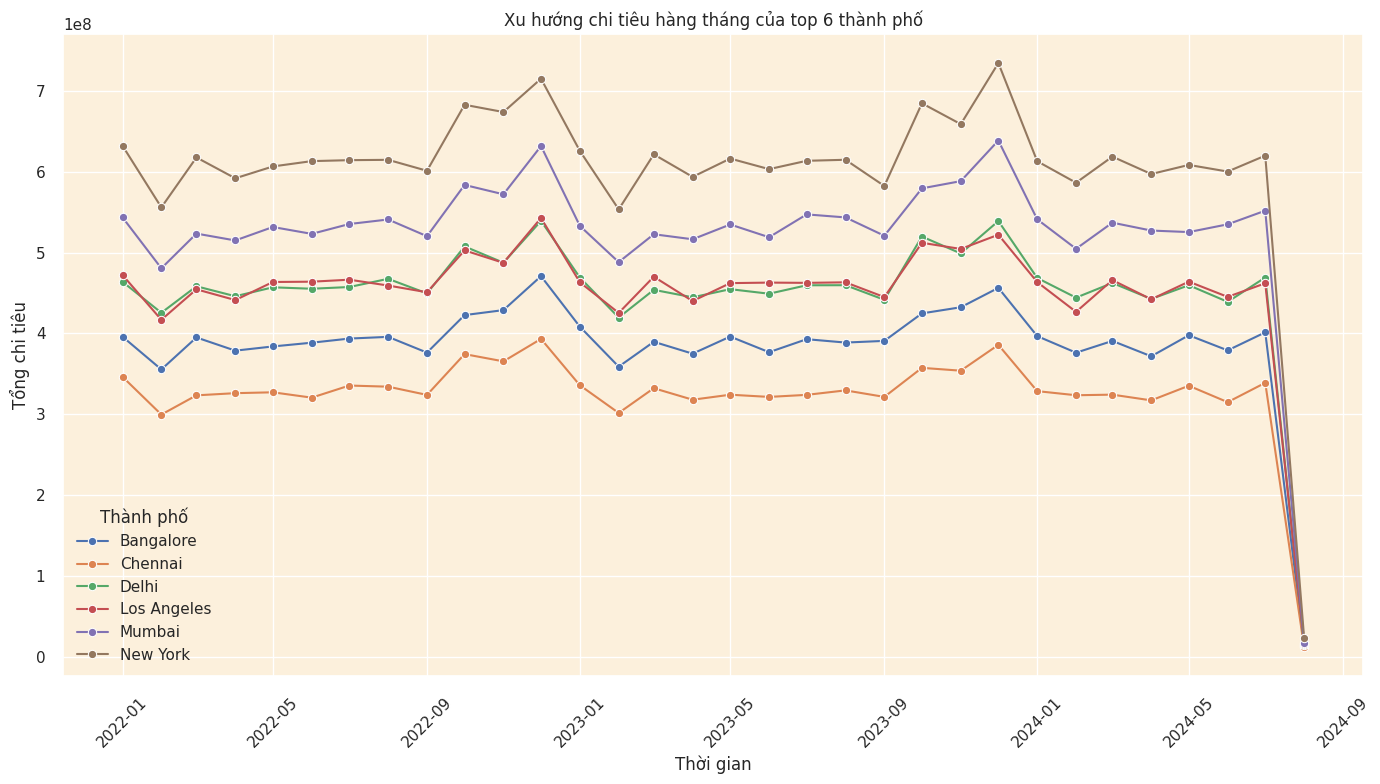

In [ ]:
top_cities_total = (
    monthly_spending
    .groupby('City')
    .agg(Total_Spend_Sum=('Total_Spend', 'sum'))
    .sort_values('Total_Spend_Sum', ascending=False)
    .head(6)
)

top_cities = top_cities_total.index.tolist()
import matplotlib.pyplot as plt
import seaborn as sns

# Lọc dữ liệu
top_cities_data = monthly_spending[monthly_spending['City'].isin(top_cities)]

# Vẽ biểu đồ đường
plt.figure(figsize=(14, 8))
sns.lineplot(data=top_cities_data, x='YearMonth', y='Total_Spend', hue='City', marker='o')

plt.title('Xu hướng chi tiêu hàng tháng của top 6 thành phố')
plt.xlabel('Thời gian')
plt.ylabel('Tổng chi tiêu')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Thành phố')
plt.show()


In [ ]:
customer_data.head(10)

,Location ID,Last Purchase Date,Recency,Frequency,Monetary,Product_Diversity,Avg_Purchase_Frequency,Avg_Days_Between_Purchases,Top_Day_of_Week,Continent
0,2,2022-02-10,903,1,3321.36,1,1.0,NaN,Thursday,Asia
1,3,2022-12-05,605,1,1244.63,1,1.0,NaN,Monday,Asia
2,5,2024-07-13,19,1,30791.05,1,1.0,NaN,Saturday,North America
3,6,2024-07-09,23,1,7192.71,1,1.0,NaN,Tuesday,North America
4,7,2022-05-22,802,1,32710.80,1,1.0,NaN,Sunday,North America
5,8,2023-05-22,437,1,18373.16,1,1.0,NaN,Monday,Asia
6,10,2022-12-20,590,1,6022.37,1,1.0,NaN,Tuesday,Asia
7,11,2022-10-12,659,1,14788.18,1,1.0,NaN,Wednesday,North America
8,12,2022-11-14,626,1,7819.23,1,1.0,NaN,Monday,Asia
9,13,2022-05-03,821,1,1631.81,1,1.0,NaN,Tuesday,Asia


In [ ]:
#customer_data.info()

#Step 5 | Outlier Detection and Treatment

In [ ]:
# Khởi tạo mô hình IsolationForest với contamination=0.05
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Chọn chỉ các cột số từ customer_data
numerical_customer_data = customer_data.select_dtypes(include=np.number)

# Chuyển DataFrame sang NumPy array để tránh cảnh báo
# Sử dụng dữ liệu số đã lọc
data_np = numerical_customer_data.values

# Fit mô hình IsolationForest với dữ liệu số
iso_forest.fit(data_np)

# Dự đoán điểm ngoại lai (-1 là outlier, 1 là inlier)
outlier_pred = iso_forest.predict(data_np)

# Tạo cột mới 'outlier' trong DataFrame GỐC để lưu nhãn ngoại lai
# Điều quan trọng là gán nhãn ngoại lai trở lại DataFrame gốc 'customer_data'
customer_data['outlier'] = outlier_pred

# Hiển thị vài hàng đầu tiên của customer_data
print(customer_data.head())

  Location ID Last Purchase Date  Recency  Frequency  Monetary  \
0           2         2022-02-10      903          1   3321.36   
1           3         2022-12-05      605          1   1244.63   
2           5         2024-07-13       19          1  30791.05   
3           6         2024-07-09       23          1   7192.71   
4           7         2022-05-22      802          1  32710.80   

   Product_Diversity  Avg_Purchase_Frequency  Avg_Days_Between_Purchases  \
0                  1                     1.0                         NaN   
1                  1                     1.0                         NaN   
2                  1                     1.0                         NaN   
3                  1                     1.0                         NaN   
4                  1                     1.0                         NaN   

  Top_Day_of_Week      Continent  outlier  
0        Thursday           Asia        1  
1          Monday           Asia        1  
2        Satur

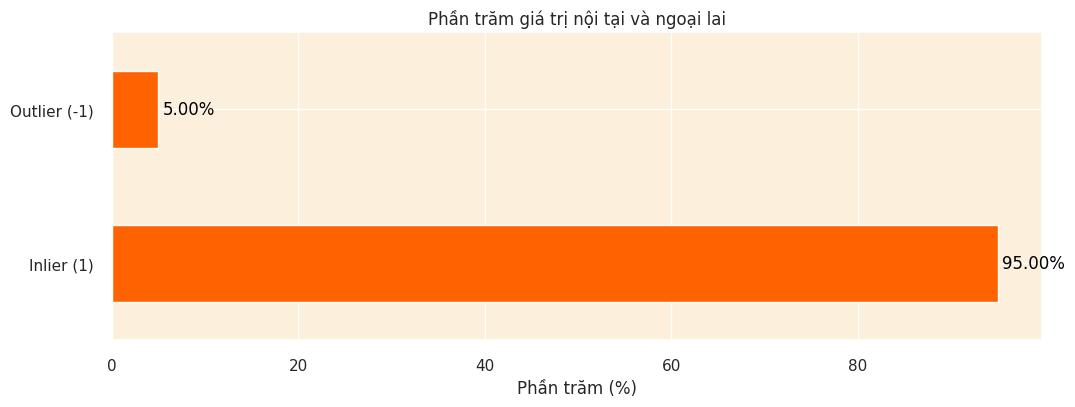

In [ ]:
# Tính số lượng mỗi nhãn (-1: outlier, 1: inlier)
counts = customer_data['outlier'].value_counts()

# Chuyển thành phần trăm
outlier_percentage = counts / counts.sum() * 100

# Đổi index thành tên dễ hiểu
outlier_percentage.index = ['Inlier (1)', 'Outlier (-1)']

# Vẽ biểu đồ thanh ngang
plt.figure(figsize=(12, 4))
ax = outlier_percentage.plot(kind='barh', color='#ff6200')

# Thêm nhãn phần trăm vào mỗi thanh
for i, v in enumerate(outlier_percentage):
    ax.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center')

plt.title('Phần trăm giá trị nội tại và ngoại lai')
plt.xlabel('Phần trăm (%)')
plt.ylabel('')
plt.show()

In [ ]:
# Tách các giá trị ngoại lệ để phân tích
# Use the correct column name 'outlier' and filter for -1 (outliers)
outliers_data = customer_data[customer_data['outlier'] == -1]

# Xóa các giá trị ngoại lai khỏi tập dữ liệu chính
# Use the correct column name 'outlier' and filter for 1 (inliers)
customer_data_cleaned = customer_data[customer_data['outlier'] == 1]

# Xóa các cột 'outlier'
# Remove the 'outlier' column as it is no longer needed in the cleaned data
customer_data_cleaned = customer_data_cleaned.drop(columns=['outlier'])

# Đặt lại chỉ mục của dữ liệu đã được làm sạch
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
# Lấy số hàng trong tập dữ liệu khách hàng đã được dọn dẹp
customer_data_cleaned.shape[0]

5978600

In [ ]:
customer_data_cleaned.head()

,Location ID,Last Purchase Date,Recency,Frequency,Monetary,Product_Diversity,Avg_Purchase_Frequency,Avg_Days_Between_Purchases,Top_Day_of_Week,Continent
0,2,2022-02-10,903,1,3321.36,1,1.0,NaN,Thursday,Asia
1,3,2022-12-05,605,1,1244.63,1,1.0,NaN,Monday,Asia
2,5,2024-07-13,19,1,30791.05,1,1.0,NaN,Saturday,North America
3,6,2024-07-09,23,1,7192.71,1,1.0,NaN,Tuesday,North America
4,7,2022-05-22,802,1,32710.80,1,1.0,NaN,Sunday,North America


In [ ]:
# xuất file customer_data_cleaned ra csv
customer_data_cleaned.to_csv('customer_data_cleaned.csv', index=False)


#Step 6 | Correlation Analysis

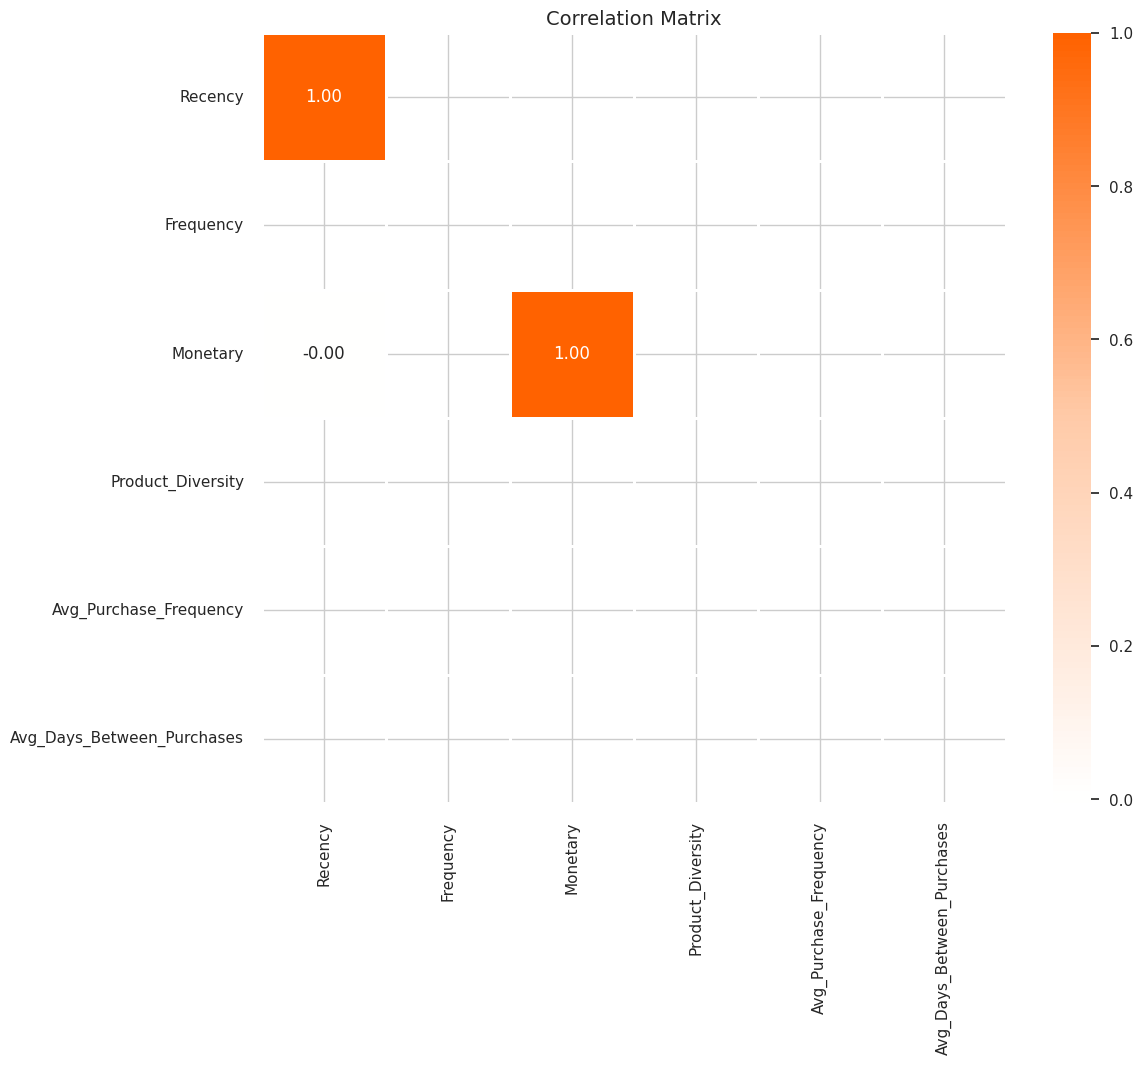

In [ ]:
# Đặt lại kiểu nền
sns.set_style('whitegrid')

# Tính toán ma trận tương quan
# Chọn chỉ các cột số từ customer_data_cleaned
numeric_cols = customer_data_cleaned.select_dtypes(include=np.number)
corr = numeric_cols.corr()

# Xác định một bản đồ màu tùy chỉnh
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Tạo mặt nạ để chỉ hiển thị tam giác dưới của ma trận (vì nó được phản chiếu xung quanh đường chéo
# từ trên cùng bên trái xuống dưới cùng bên phải)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Vẽ bản đồ nhiệt
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

#Step 7 | Feature Scaling

In [ ]:
# Khởi tạo StandardScaler
scaler = StandardScaler()

# Danh sách các cột không cần phải thu nhỏ (bao gồm Location ID, City, Country, Continent, etc.)
# Select only numerical columns to scale
numerical_columns_to_scale = customer_data_cleaned.select_dtypes(include=np.number).columns

# Sao chép tập dữ liệu đã được làm sạch
customer_data_scaled = customer_data_cleaned.copy()

# Áp dụng bộ chia tỷ lệ chỉ cho các cột số
customer_data_scaled[numerical_columns_to_scale] = scaler.fit_transform(customer_data_scaled[numerical_columns_to_scale])

# Hiển thị một vài hàng đầu tiên của dữ liệu được chia tỷ lệ
customer_data_scaled.head()

,Location ID,Last Purchase Date,Recency,Frequency,Monetary,Product_Diversity,Avg_Purchase_Frequency,Avg_Days_Between_Purchases,Top_Day_of_Week,Continent
0,2,2022-02-10,1.616458,0.0,-0.504810,0.0,0.0,NaN,Thursday,Asia
1,3,2022-12-05,0.503799,0.0,-0.591713,0.0,0.0,NaN,Monday,Asia
2,5,2024-07-13,-1.684181,0.0,0.644686,0.0,0.0,NaN,Saturday,North America
3,6,2024-07-09,-1.669246,0.0,-0.342809,0.0,0.0,NaN,Tuesday,North America
4,7,2022-05-22,1.239349,0.0,0.725020,0.0,0.0,NaN,Sunday,North America


In [ ]:
customer_data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978600 entries, 0 to 5978599
Data columns (total 10 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Location ID                 object        
 1   Last Purchase Date          datetime64[ns]
 2   Recency                     float64       
 3   Frequency                   float64       
 4   Monetary                    float64       
 5   Product_Diversity           float64       
 6   Avg_Purchase_Frequency      float64       
 7   Avg_Days_Between_Purchases  float64       
 8   Top_Day_of_Week             object        
 9   Continent                   object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 456.1+ MB


In [ ]:
# xuất file customer_data_scaled ra csv
customer_data_scaled.to_csv('customer_data_scaled.csv', index=False)


In [ ]:
customer_data_scaled.shape

(5978600, 10)

#Step 8 | Dimensionality Reduction

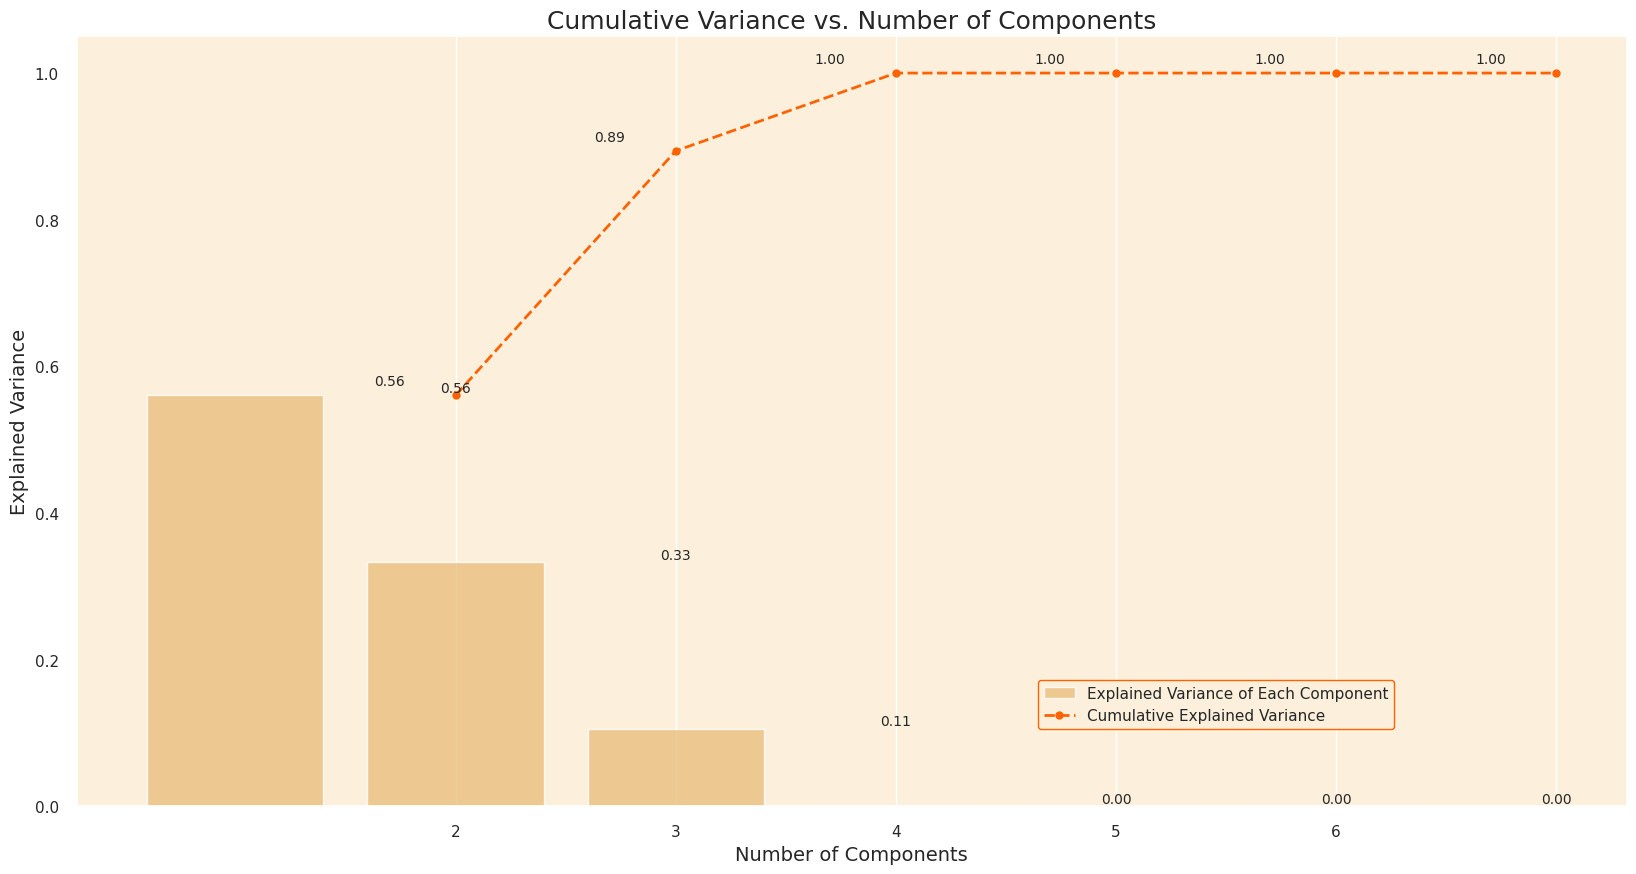

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Chọn cột số từ customer_data
numerical_cols_for_pca = customer_data.select_dtypes(include=np.number)

# Xử lý missing values: thay NaN bằng mean của từng cột
imputer = SimpleImputer(strategy='mean')
customer_data_imputed = imputer.fit_transform(numerical_cols_for_pca)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_imputed)

# Số thành phần PCA phù hợp (tối đa là số cột hoặc 6)
n_components_pca = min(numerical_cols_for_pca.shape[1], 6)

# Áp dụng PCA
pca = PCA(n_components=n_components_pca)
pca.fit(customer_data_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Vẽ biểu đồ
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')
plt.figure(figsize=(20, 10))

barplot = sns.barplot(
    x=list(range(1, len(explained_variance_ratio) + 1)),
    y=explained_variance_ratio,
    color='#fcc36d',
    alpha=0.8
)

barplot_patches = barplot.patches

lineplot, = plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker='o', linestyle='--', color='#ff6200', linewidth=2
)

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)
plt.xticks(range(1, n_components_pca + 1))

# Thêm chú thích
plt.legend(handles=[barplot_patches[0], lineplot],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance'],
           loc=(0.62, 0.1),
           frameon=True, framealpha=1.0, edgecolor='#ff6200')

# Ghi số cụ thể trên biểu đồ
x_offset = -0.3
y_offset = 0.01
for i, cum_ev_ratio in enumerate(cumulative_explained_variance):
    plt.text(i + 1, explained_variance_ratio[i], f"{explained_variance_ratio[i]:.2f}", ha="center", va="bottom", fontsize=10)
    plt.text(i + 1 + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()


In [ ]:
# Lọc cột số
numerical_cols_for_pca = customer_data.select_dtypes(include=np.number)

# Thay NaN bằng mean
imputer = SimpleImputer(strategy='mean')
customer_data_imputed = imputer.fit_transform(numerical_cols_for_pca)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data_imputed)

# Áp dụng PCA với tối đa 6 thành phần
max_components = min(6, numerical_cols_for_pca.shape[1])
pca = PCA(n_components=max_components)
customer_data_pca_values = pca.fit_transform(customer_data_scaled)

# Lấy explained variance ratio để lọc các PC có ý nghĩa (giá trị > ngưỡng nhỏ)
explained_variance_ratio = pca.explained_variance_ratio_

# Ngưỡng nhỏ để loại bỏ các thành phần gần bằng 0 (ví dụ 1e-5)
threshold = 1e-5
valid_components = [i for i, var in enumerate(explained_variance_ratio) if var > threshold]

# Chỉ giữ các PC có explained variance > threshold
customer_data_pca_values_filtered = customer_data_pca_values[:, valid_components]

# Tạo DataFrame kết quả với các PC hợp lệ
customer_data_pca = pd.DataFrame(
    customer_data_pca_values_filtered,
    columns=[f'PC{i+1}' for i in valid_components]
)

# Thêm Location ID nếu có
if 'Location ID' in customer_data.columns:
    customer_data_pca['Location ID'] = customer_data['Location ID'].values

print(customer_data_pca.head())


        PC1       PC2       PC3 Location ID
0  0.477728  1.596936 -0.145949           2
1  0.539663  0.506060 -0.212951           3
2  0.003654 -1.667800  0.313027           5
3  0.464947 -1.632984 -0.148151           6
4 -0.089900  1.201515  0.419902           7


In [ ]:
# Hiển thị khung dữ liệu kết quả dựa trên PC
customer_data_pca.head()

,PC1,PC2,PC3,Location ID
0,0.477728,1.596936,-0.145949,2
1,0.539663,0.506060,-0.212951,3
2,0.003654,-1.667800,0.313027,5
3,0.464947,-1.632984,-0.148151,6
4,-0.089900,1.201515,0.419902,7


In [ ]:
# Đặt lại chỉ mục nếu cần
customer_data_pca = customer_data_pca.reset_index(drop=True)

# Di chuyển 'Location ID' vào cột đầu tiên (nếu đang ở cột khác)
location_id_column = customer_data_pca.pop('Location ID')
customer_data_pca.insert(0, 'Location ID', location_id_column)

# Hiển thị DataFrame
print(customer_data_pca.head())


  Location ID       PC1       PC2       PC3
0           2  0.477728  1.596936 -0.145949
1           3  0.539663  0.506060 -0.212951
2           5  0.003654 -1.667800  0.313027
3           6  0.464947 -1.632984 -0.148151
4           7 -0.089900  1.201515  0.419902


In [ ]:
# xuất file customer_data_pca ra csv
customer_data_pca.to_csv('customer_data_pca.csv', index=False)
